<a target="_blank" href="https://colab.research.google.com/github/mrdbourke/learn-huggingface/blob/main/notebooks/hugging_face_text_classification_tutorial.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
# Next:
# Add tools used in this overview (e.g. overview of the project)
# Create a small dataset with text generation, e.g. 50x spam/not_spam emails and train a classifier on it ✅
   # Done, see notebook: https://colab.research.google.com/drive/14xr3KN_HINY5LjV0s2E-4i7v0o_XI3U8?usp=sharing 
# Save the dataset to Hugging Face Datasets ✅
   # Done, see dataset: https://huggingface.co/datasets/mrdbourke/learn_hf_food_not_food_image_captions
# Train a classifier on it ✅
# Save the model to the Hugging Face Model Hub ✅
# Create a with Gradio and test the model in the wild ✅ 

## TK - Overview

### TK - What we're going to build

In this project, we're going to learn various aspects of the Hugging Face ecosystem whilst building a text classification model.

To keep things as practical as possible, we're going to be bulding a `food`/`not_food` text classification model. 

Given a piece of a text, our model will be able to predict if it's about food or not.

This is the same kind of model I use in my own work on [Nutrify](https://www.nutrify.app) (an app to help people learn about food).

More specifically, we're going to follow the following steps:

1. **Problem defintion and dataset preparation** - Getting a dataset/setting up the problem space.
2. **Finding, training and evaluating a model** - Finding a text classification model suitable for our problem on Hugging Face and customizing it to our own dataset.
3. **Creating a demo and put our model into the real world** - Sharing our trained model in a way others can access and use.

By the end of this project, you'll have a trained model and [demo on Hugging Face](https://huggingface.co/spaces/mrdbourke/learn_hf_food_not_food_text_classifier_demo) you can share with others.

TK image - see the finished product (demo)

::: {.callout-note}
Note this is a hands-on project, so we'll be focused on writing reusable code and building a model that can be used in the real world. If you are looking for explainers to the theory of what we're doing, I'll leave links in the extra-curriculum section.
::: 


### TK - What is Hugging Face?

TK - perhaps put this in the front of the website? e.g. on the index page

Hugging Face is a platform that offers access to many different kinds of open-source machine learning models and datasets.

They're also the creators of the popular `transformers` library which is a Python-based library for working with pre-trained models as well as custom models and datasets.

If you're getting into the world of AI and machine learning, you're going to come across Hugging Face.



### TK - Why Hugging Face?

Many of the biggest companies in the world use Hugging Face for their open-source machine learning projects including [Apple](https://huggingface.co/apple), [Google](https://huggingface.co/google), [Facebook](https://huggingface.co/facebook) (Meta), [Microsoft](https://huggingface.co/microsoft), [OpenAI](https://huggingface.co/openai), [ByteDance](https://huggingface.co/ByteDance) and more.

TK image - image of people using Hugging Face

Not only does Hugging Face make it so you can use state-of-the-art machine learning models such as [Stable Diffusion](https://huggingface.co/stabilityai/stable-diffusion-2-1) (for image generation) and [Whipser](https://huggingface.co/openai/whisper-large-v3) (for audio transcription) easily, it also makes it so you can share your own models, datasets and resources.

Consider Hugging Face the homepage of your AI/machine learning profile.


### TK - What is text classification?

Text classification is the process of assigning a category to a piece of text.

Where a category can be almost anything and a piece of text can be a word, phrase, sentence, paragraph or entire document.

TK image - example of text classification

Example text classification problems include:

| **Problem** | **Description** | **Problem Type** |
|-----|-----|-----|
| Spam email detection | Is an email spam or not spam? | Binary classification (one thing or another) |
| Sentiment analysis | Is a piece of text positive, negative or neutral? | Multi-class classification (one thing from many) |
| Language detection | What language is a piece of text written in? | Multi-class classification (one thing from many) |
| Topic classification | What topic(s) does a news article belong to? | Multi-label classification (one or more things from many) |
| Hate speech detection | Is a comment hateful or not hateful? | Binary classification (one thing or another) |
| Product categorization | What categories does a product belong to? | Multi-label classification (one or more things from many) |

There are several different kinds of models you can use for text classification.

And each will have its pros and cons depending on the problem you're working on.

Example text classification models include:

| **Model** | **Description** | **Pros** | **Cons** |
|-----|-----|-----|-----|
| Rule-based | Uses a set of rules to classify text (e.g. if text contains "sad" -> sentiment = low) | Simple, easy to understand | Requires manual creation of rules |
| [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model) | Counts the frequency of words in a piece of text | Simple, easy to understand | Doesn't capture word order |
| [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) | Weighs the importance of words in a piece of text | Simple, easy to understand | Doesn't capture word order |
| Deep learning-based models | Uses neural networks to learn patterns in text | Can learn complex patterns at scale | Can require large amounts of data/compute power to run, not as easy to understand (can be hard to debug) |

We're going to use a deep learning model our case.

Why?

Because Hugging Face helps us do so.

And in most cases, with a large enough dataset, a deep learning model will often perform better than a rule-based or other model.


### TK - Why train your own text classification models?

You can use pre-trained models for text classification as well as API-powered models and LLMs such as GPT-4 or Gemini.

However, it's often a good idea to train your own text classification models for a few reasons:

* They can be much faster than API-powered models (since they're running on your own hardware, this can save on costs and time).
* They're customized to your own data.
* They don't require you to send your data elsewhere (privacy).
* If a service goes down, you'll still have access to your model (reliability).

TK image - example of training your own model vs using an API-powered model


## TK - Importing necessary libraries

Let's get started!

First, we'll import the required libraries.

If you're running on your local computer, be sure to check out the getting setup guide (tk - link to getting setup guide) to make sure you have everything you need.

If you're using Google Colab, many of them the following libraries will be installed by default.

However, we'll have to install a few extras to get everything working.

::: {.callout-note}
If you're running on Google Colab, this notebook will work best with access to a GPU. To enable a GPU, go to `Runtime` ➡️ `Change runtime type` ➡️ `Hardware accelerator` ➡️ `GPU`.
::: 

We'll need to install the following libraries from the Hugging Face ecosystem:

* [`transformers`](https://huggingface.co/docs/transformers/en/installation) - comes pre-installed on Google Colab but if you're running on your local machine, you can install it via `pip install transformers`.
* [`datasets`](https://huggingface.co/docs/datasets/installation) - a library for accessing and manipulating datasets on and off the Hugging Face Hub, you can install it via `pip install datasets`.
* [`evaluate`](https://huggingface.co/docs/evaluate/installation) - a library for evaluating machine learning model performance with various metrics, you can install it via `pip install evaluate`.
* [`accelerate`](https://huggingface.co/docs/accelerate/basic_tutorials/install) - a library for training machine learning models faster, you can install it via `pip install accelerate`.
* [`gradio`](https://www.gradio.app/guides/quickstart#installation) - a library for creating interactive demos of machine learning models, you can install it via `pip install gradio`.

We can also check the versions of our software with `package_name.__version__`.

In [6]:
# Install dependencies (this is mostly for Google Colab, as the other dependences are available by default in Colab)
try:
  import datasets, evaluate, accelerate
  import gradio as gr
except ModuleNotFoundError:
  !pip install -U datasets evaluate accelerate gradio # -U stands for "upgrade" so we'll get the latest version by default
  import datasets, evaluate, accelerate
  import gradio as gr

import os
import random

import numpy as np
import pandas as pd

import torch
import transformers

from datasets import Dataset

print(f"Using transformers version: {transformers.__version__}")
print(f"Using datasets version: {datasets.__version__}")
print(f"Using torch version: {torch.__version__}")

Using transformers version: 4.41.2
Using datasets version: 2.19.1
Using torch version: 2.2.0+cu121


Wonderful, as long as your versions are the same or higher to the versions above, you should be able to run the code below.

## TK - Getting a dataset

Okay, now we're got the required libraries, let's get a dataset.

Getting a dataset is one of the most important things a machine learning project.

The dataset you often determines the type of model you use as well as the quality of the outputs of that model.

Meaning, if you have a high quality dataset, chances are, your future model could also have high quality outputs.

It also means if your dataset is of poor quality, your model will likely also have poor quality outputs.

For a text classificaiton problem, your dataset will likely come in the form of text (e.g. a paragraph, sentence or phrase) and a label (e.g. what category the text belongs to).

* TK image - showcase what a supervised dataset looks like (e.g. text and label, this can be the dataset we've got on Hugging Face hub, showcase the different parts of the dataset as well including the name etc)

In our case, our dataset comes in the form of a collection of synthetic image captions and their corresponding labels (food or not food).

This is a dataset I've created earlier to help us practice building a text classification model.

You can find it on Hugging Face under the name [`mrdbourke/learn_hf_food_not_food_image_captions`](https://huggingface.co/datasets/mrdbourke/learn_hf_food_not_food_image_captions).

::: {.callout-tip}
## Resource

See how the food/not_food image caption dataset was created in the (TK - add notebook link and title, make this available on the website)

* TK - see dataset creation: 
   * Done, see notebook: https://colab.research.google.com/drive/14xr3KN_HINY5LjV0s2E-4i7v0o_XI3U8?usp=sharing 
   * Done, see dataset: https://huggingface.co/datasets/mrdbourke/learn_hf_food_not_food_image_captions
:::

### Where can you get more datasets?

The are many different places you can get datasets for text-based problems.

One of the best places is on the Hugging Face Hub, specifically [huggingface.co/datasets](https://huggingface.co/datasets).

Here you can find many different kinds of problem specific data such as [text classification](https://huggingface.co/datasets?task_categories=task_categories:text-classification&sort=trending).

TK image - show example image of text classification datasets

### Loading the dataset

Once we've found/prepared a dataset on the Hugging Face Hub, we can use the `datasets` library to load it.

To load a dataset we can use the [`datasets.load_dataset(path=NAME_OR_PATH_OF_DATASET)`](https://huggingface.co/docs/datasets/v2.20.0/en/package_reference/loading_methods#datasets.load_dataset) function and pass it the name/path of the dataset we want to load.

In our case, our dataset name is `mrdbourke/learn_hf_food_not_food_image_captions`.

And since our dataset is hosted on Hugging Face, when we run the following code for the first time, it will download it.

If your target dataset is quite large, this download may take a while.

However, once the dataset is downloaded, subsequent reloads will be mush faster.

In [7]:
# Load the dataset from Hugging Face Hub
dataset = datasets.load_dataset(path="mrdbourke/learn_hf_food_not_food_image_captions")

# Inspect the dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 250
    })
})

Dataset loaded!

Looks like our dataset has two features, `text` and `label`.

And 250 total rows (the number of examples in our dataset).

We can check the column names with `dataset.column_names`.

In [9]:
# What features are there?
dataset.column_names

{'train': ['text', 'label']}

Looks like our dataset comes with a `train` split already (the whole dataset).

We can access the `train` split with `dataset["train"]` (some datasets also come with built-in `"test"` splits too).

In [10]:
# Access the training split
dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 250
})

How about we check out a single sample?

We can do so with indexing.

In [11]:
dataset["train"][0]

{'text': 'Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
 'label': 'food'}

Nice! We get back a dictionary with the keys `text` and `label`.

The `text` key contains the text of the image caption and the `label` key contains the label (food or not food).

### TK - Inspect random examples from the dataset

At 250 total samples, our dataset isn't too large.

So we could sit there and explore the samples one by one.

But whenever I interact with a new dataset, I like to view a bunch of random examples and get a *feel* of the data.

Doing so is inline with the data explorer's motto: *visualize, visualize, visualize!* 

As a rule of thumb, I like to view at least 20-100 random examples when interacting with a new dataset.

Let's write some code to view 5 random indexes of our data and their corresponding text and labels at a time.

In [12]:
import random

random_indexs = random.sample(range(len(dataset["train"])), 5)
random_samples = dataset["train"][random_indexs]

print(f"[INFO] Random samples from dataset:\n")
for item in zip(random_samples["text"], random_samples["label"]):
    print(f"Text: {item[0]} | Label: {item[1]}")

[INFO] Random samples from dataset:

Text: Luxurious coconut shrimp curry on a generous plate, featuring succulent shrimp in a rich coconut milk sauce, served with jasmine rice. | Label: food
Text: Set of golf clubs stored in a bag | Label: not_food
Text: A bowl of sliced pears with a sprinkle of ginger and a side of honey | Label: food
Text: Celery in a bowl, served with a side of peanut butter and a sprinkle of raisins for a classic, tasty snack. | Label: food
Text: Set of forks kept in a holder | Label: not_food


Beautiful! Looks like our data contains a mix of shorter and longer sentences (between 5 and 20 words) of texts about food and not food.

We can get the unique labels in our dataset with [`dataset["train"].unique("label")`](https://huggingface.co/docs/datasets/v2.20.0/en/package_reference/main_classes#datasets.Dataset.unique).

In [13]:
# Get unique label values
dataset["train"].unique("label")

['food', 'not_food']

If our dataset is small enough to fit into memory, we can count the number of different labels with Python's [`collections.Counter`](https://docs.python.org/3/library/collections.html#counter-objects) (a method for counting objects in an iterable or mapping).

In [14]:
# Check number of each label
from collections import Counter

Counter(dataset["train"]["label"])

Counter({'food': 125, 'not_food': 125})

Excellent, looks like our dataset is well balanced with 125 samples of food and 125 samples of not food.

In a binary classification case, this is ideal.

If the classes were dramatically unbalanced (e.g. 90% food and 10% not food) we might have to consider collecting/creating more data.

But best to train a model and see how it goes before making any drastic dataset changes.

Because our dataset is small, we could also inspect it via a pandas DataFrame (however, this may not be possible for extremely large datasets).

In [15]:
# Turn our dataset into a DataFrame and get a random sample
food_not_food_df = pd.DataFrame(dataset["train"])
food_not_food_df.sample(7)

,text,label
249,"Taking a nap on a hammock, a man has his dog s...",not_food
7,Set of muffin tins stacked together,not_food
170,Colorful area rug brightening up a living room,not_food
40,Wall clock ticking away in a living room,not_food
188,A basket of fresh strawberries with a sprinkle...,food
154,Gluten-free sushi roll using tamari sauce inst...,food
0,"Creamy cauliflower curry with garlic naan, fea...",food


In [16]:
# Get the value counts of the label column
food_not_food_df["label"].value_counts()

label
food        125
not_food    125
Name: count, dtype: int64

## TK - Preparing data for text classification

We've got our data ready but there are a few steps we'll need to take before we can model it.

The main two being:

1. **Tokenization** - turning our text into a numerical representation (machines prefer numbers rather than words), for example, `{"a": 0, "b": 1, "c": 2...}`.
2. **Creating a train/test split** - right now our data is in a training split only but we'll create a test set to evaluate our model's performance.

These don't necessarily have to be in order either.

Before we get to them, let's create a small mapping from our labels to numbers.

In the same way we need to tokenize our text into numerical representation, we also need to do the same for our labels.

### TK - Creating a mapping from labels to numbers

Our machine learning model will want to see all numbers.

This goes for text as well as label input.

So let's create a mapping from our labels to numbers.

Since we've only got a couple of labels (`"food"` and `"not_food"`), we can create a dictionary to map them to numbers, however, if you've got a fair few labels, you may want to make this mapping programmatically.

We can use these dictionaries later on for our model training as well as evaluation.

In [17]:
# Create mapping from id2label and label2id
id2label = {0: "not_food", 1: "food"}
label2id = {"not_food": 0, "food": 1}

print(f"Label to ID mapping: {label2id}")
print(f"ID to Label mapping: {id2label}")

Label to ID mapping: {'not_food': 0, 'food': 1}
ID to Label mapping: {0: 'not_food', 1: 'food'}


::: {.callout-note}
In a binary classification task, the positive class, in our case `"food"`, is usually given the label `1` and the negative class (`"not_food"`) is given the label `0`. 
:::

In [18]:
# Create mappings programmatically from dataset
id2label = {idx: label for idx, label in enumerate(dataset["train"].unique("label")[::-1])} # reverse sort list to have "not_food" first
label2id = {label: idx for idx, label in id2label.items()}

print(f"Label to ID mapping: {label2id}")
print(f"ID to Label mapping: {id2label}")

Label to ID mapping: {'not_food': 0, 'food': 1}
ID to Label mapping: {0: 'not_food', 1: 'food'}


With our dictionary mappings created, we can update the labels of our dataset to be numeric.

We can do this using the [`datasets.Dataset.map`](https://huggingface.co/docs/datasets/en/process#map) method and passing it a function to apply to each example.

Let's create a small function which turns an example label into a number.

In [19]:
# Turn labels into 0 or 1 (e.g. 0 for "not_food", 1 for "food")
def map_labels_to_number(example):
  example["label"] = label2id[example["label"]]
  return example

example_sample = {"text": "This is a sentence about my favourite food: honey.", "label": "food"}

# Test the function
map_labels_to_number(example_sample)

{'text': 'This is a sentence about my favourite food: honey.', 'label': 1}

Looks like our function works!

How about we map it to the whole dataset?

In [20]:
# Map our dataset labels to numbers
dataset = dataset["train"].map(map_labels_to_number)
dataset[:5]

{'text': ['Creamy cauliflower curry with garlic naan, featuring tender cauliflower in a rich sauce with cream and spices, served with garlic naan bread.',
  'Set of books stacked on a desk',
  'Watching TV together, a family has their dog stretched out on the floor',
  'Wooden dresser with a mirror reflecting the room',
  'Lawn mower stored in a shed'],
 'label': [1, 0, 0, 0, 0]}

Nice! Looks like our labels are all numerical now.

We can check a few random samples using [`dataset.shuffle()`](https://huggingface.co/docs/datasets/en/process#shuffle) and indexing for the first few.

In [21]:
# Shuffle the dataset and view the first 5 samples (will return different results each time) 
dataset.shuffle()[:5]

{'text': ['Treadmill available in a home gym',
  'Potatoes, onions, garlic, cauliflower, and broccolini in boxes at the market, ready for a tasty, healthy meal.',
  'A slice of pizza with a generous amount of shredded parmesan cheese on top',
  'A bowl of sliced bell peppers with a sprinkle of paprika and a side of hummus',
  'Set of forks kept in a holder'],
 'label': [0, 1, 1, 1, 0]}

### TK - Split the dataset into training and test sets

Right now our dataset only has a training split.

However, we'd like to create a test split so we can evaluate our model.

In essence, our model will learn patterns (the relationship between text captions and their labels of food/not_food) on the training data.

And we will evaluate those learned patterns on the test data.

We can split our data using the [`datasets.Dataset.train_test_split`](https://huggingface.co/docs/datasets/v2.20.0/en/package_reference/main_classes#datasets.Dataset.train_test_split) method.

We can use the `test_size` parameter to define the percentage of data we'd like to use in our test set (e.g. `test_size=0.2` would mean 20% of the data goes to the test set).

In [22]:
# Create train/test splits
dataset = dataset.train_test_split(test_size=0.2, seed=42) # note: seed isn't needed, just here for reproducibility, without it you will get different splits each time you run the cell
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
})

Perfect!

Our dataset has been split into 200 training examples and 50 testing examples.

Let's visualize a few random examples to make sure they still look okay.

In [23]:
random_idx_train = random.randint(0, len(dataset["train"]))
random_sample_train = dataset["train"][random_idx_train]

random_idx_test = random.randint(0, len(dataset["test"]))
random_sample_test = dataset["test"][random_idx_test]

print(f"[INFO] Random sample from training dataset:")
print(f"Text: {random_sample_train['text']}\nLabel: {random_sample_train['label']} ({id2label[random_sample_train['label']]})\n")
print(f"[INFO] Random sample from testing dataset:")
print(f"Text: {random_sample_test['text']}\nLabel: {random_sample_test['label']} ({id2label[random_sample_test['label']]})")

[INFO] Random sample from training dataset:
Text: A couple enjoying a movie night on the couch with their pets snuggled close
Label: 0 (not_food)

[INFO] Random sample from testing dataset:
Text: A bowl of sliced kiwi with a sprinkle of sugar and a side of yogurt
Label: 1 (food)


### TK - Tokenizing text data

Labels numericalized, dataset split, time to turn our text into numbers.

Tokenization is the process of converting a non-numerical data source into numbers.

Why?

Because machines (especially machine learning models) prefer numbers to human-style data.

In the case of the text `"I love pizza"` a very simple method of tokenization might be to convert each word to a number.

For example, `{"I": 0, "love": 1, "pizza": 2}`.

However, for most modern machine learning models, the tokenization process is a bit more nuanced.

For example, the text `"I love pizza"` might be tokenized into something more like `[101, 1045, 2293, 10733, 102]`.

TK image - showcase an example using OpenAI's tokenization tool and what this looks like with "I love pizza": https://platform.openai.com/tokenizer  

::: {.callout-note}
Depending on the model you use, the tokenization process could be different. For example, one model might turn `"I love pizza"` into `[40, 3021, 23317]`, where as another model might turn it into `[101, 1045, 2293, 10733, 102]`. 

To deal with this, Hugging Face models often pair models with their own tokenizers by pairing a tokenizer configuration with a model's weights. 

Such is the case with [`distilbert/distilbert-base-uncased`](https://huggingface.co/distilbert/distilbert-base-uncased) (there is a `tokenizer.json` file as well as a `tokenizer_config.json` file which contains all of the tokenizer implementation details). 

For more examples of tokenization, you can see OpenAI's [tokenization visualizer tool](https://platform.openai.com/tokenizer) as well as their open-source library [`tiktoken`](https://github.com/openai/tiktoken), Google also have an open-source tokenization library called [`sentencepiece`](https://github.com/google/sentencepiece), finally Hugging Face's [`tokenizers`](https://github.com/huggingface/tokenizers) library is also a great resource (this is what we'll be using behind the scenes).
:::

Many of the text-based models on Hugging Face come paired with their own tokenizer.

For example, the [`distilbert/distilbert-base-uncased`](https://huggingface.co/distilbert/distilbert-base-uncased) model can be used with the `distilbert/distilbert-base-uncased` tokenizer.

We can load the tokenizer for a given model using the [`transformers.AutoTokenizer.from_pretrained`](https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes) method and passing it the name of the model we'd like to use.

The `transformers.AutoTokenizer` class is part of a series of Auto Classes (such as `AutoConfig`, `AutoModel`, `AutoProcessor`) which automatically loads the correct configuration settings for a given model.

Let's load the tokenizer for the `distilbert/distilbert-base-uncased` model and see how it works.

UPTOHERE - "why this model?", add reasoning to why the distilbert model, Hugging Face has many models, often it takes a bit of practice to see which is best to use

:::{.callout-note}
Why use the `distilbert/distilbert-base-uncased` model?

The short answer is that I've used it before and it works well (and fast) on various text classification tasks.

The longer answer is that Hugging Face has many available open-source models for many different problems available at [https://huggingface.co/models](https://huggingface.co/models).

Navigating these models can take some practice.

And several models may be suited for the same task (though with various tradeoffs such as size and speed).

However, overtime and with adequate experimentation, you'll start to build an intuition on which models are good for which problems.
:::

In [24]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
                                          use_fast=True) # uses fast tokenization (backed by tokenziers library and implemented in Rust) by default, if not available will default to Python implementation

tokenizer

DistilBertTokenizerFast(name_or_path='distilbert/distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

Nice!

There's our tokenizer!

It's an instance of the [`transformers.DistilBertTokenizerFast`](https://huggingface.co/docs/transformers/v4.41.3/en/model_doc/distilbert#transformers.DistilBertTokenizerFast) class.

You can read more about it in the documentation.

For now, let's try it out by passing it a string of text.

In [25]:
# Test out tokenizer
tokenizer("I love pizza")

{'input_ids': [101, 1045, 2293, 10733, 102], 'attention_mask': [1, 1, 1, 1, 1]}

In [26]:
# Try adding a "!" at the end
tokenizer("I love pizza!")

{'input_ids': [101, 1045, 2293, 10733, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1]}

Woohoo!

Our text gets turned into numbers (or tokens).

Notice how with even a slight change in the text, the tokenizer produces different results?

The `input_ids` are our tokens.

And the `attention_mask` (in our case, all `[1, 1, 1, 1, 1, 1]`) is a mask which tells the model which tokens to use or not. Tokens with a mask value of `1` get used and tokens with a mask value of `0` get ignored.

There are several attributes of the `tokenizer` we can explore.

* `tokenizer.vocab` will return the vocabulary of the tokenizer or in other words, the unique words/word pieces the tokenizer is capable of converting into numbers.
* `tokenizer.model_max_length` will return the maximum length of a sequence the tokenizer can process, pass anything longer than this and the sequence will be truncated.

In [27]:
# Get the length of the vocabulary 
length_of_tokenizer_vocab = len(tokenizer.vocab)
print(f"Length of tokenizer vocabulary: {length_of_tokenizer_vocab}")

# Get the maximum sequence length the tokenizer can handle
max_tokenizer_input_sequence_length = tokenizer.model_max_length
print(f"Max tokenizer input sequence length: {max_tokenizer_input_sequence_length}")

Length of tokenizer vocabulary: 30522
Max tokenizer input sequence length: 512


Woah, looks like our tokenizer has a vocabulary of `30,522` different words and word pieces.

And it can handle a sequence length of up to `512` (any sequence longer than this will be automatically truncated from the end).

Let's check out some of the vocab.

Can I find my own name?

In [28]:
# Does "daniel" occur in the vocab?
tokenizer.vocab["daniel"]

3817

Oooh, looks like my name is `3817` in the tokenizer's vocab.

Can you find your own name? (note: there may be an error if the token doesn't exist, we'll get to this)

How about "pizza"?

In [29]:
tokenizer.vocab["pizza"]

10733

What if a word doesn't exist in the vocab?

In [30]:
tokenizer.vocab["akash"]

KeyError: 'akash'

Dam, we get a `KeyError`.

Not to worry, this is okay, since when calling the `tokenizer` on the word, it will automatically split the word into word pieces or subwords.

In [31]:
tokenizer("akash")

{'input_ids': [101, 9875, 4095, 102], 'attention_mask': [1, 1, 1, 1]}

It works!

We can check what word pieces `"akash"` got broken into with [`tokenizer.convert_ids_to_tokens(input_ids)`](https://huggingface.co/docs/transformers/en/main_classes/tokenizer#transformers.PreTrainedTokenizerFast.convert_ids_to_tokens).

In [32]:
tokenizer.convert_ids_to_tokens(tokenizer("akash").input_ids)

['[CLS]', 'aka', '##sh', '[SEP]']

Ahhh, it seems `"akash"` was split into two tokens, `["aka", "##sh"]`.

The `"##"` at the start of `"##sh"` means that the sequence is part of a larger sequence. 

And the `"[CLS]"` and `"[SEP]"` tokens are special tokens indicating the start and end of a sequence.

Now, since tokenizers can deal with any text, what if there was an unknown token?

For example, rather than `"pizza"` someone used the pizza emoji 🍕?

Let's try!

In [33]:
# Try to tokenize an emoji
tokenizer.convert_ids_to_tokens(tokenizer("🍕").input_ids)

['[CLS]', '[UNK]', '[SEP]']

Ahh, we get the special `"[UNK]"` token.

This stands for "unknown".

The combination of word pieces and `"[UNK]"` special token means that our `tokenizer` will be able to turn almost any text into numbers for our model.

::: {.callout-note}
Keep in mind that just because one tokenizer uses an unknown special token for a particular word or emoji (🍕) doesn't mean another will.
:::

Since the `tokenizer.vocab` is a Python dictionary, we can get a sample of the vocabulary using `tokenizer.vocab.items()`.

How about we get the first 5?

In [34]:
# Get the first 5 items in the tokenizer vocab
sorted(tokenizer.vocab.items())[:5]

[('!', 999), ('"', 1000), ('#', 1001), ('##!', 29612), ('##"', 29613)]

There's our `'!'` from before! Looks like the first five items are all related to punctuation points.

How about a random sample of tokens?

In [35]:
import random

random.sample(sorted(tokenizer.vocab.items()), k=5)

[('macau', 16878),
 ('##nia', 6200),
 ('resurrection', 15218),
 ('drops', 9010),
 ('organizers', 18829)]

### TK - Making a preprocessing function to tokenize text

Rather than tokenizing our texts one by one, it's best practice to define a preprocessing function which does it for us.

This process works regardless of whether you're working with text data or other kinds of data such as images or audio.

::: {.callout-tip}
## Turning data into numbers

For any kind of machine learning workflow, an important first step is turning your input data into numbers.

As machine learning models are algorithms which find patterns in numbers, before they can find patterns in your data (text, images, audio, tables) it must be numerically encoded first (e.g. tokenizing text).

To help with this, `transformers` has an [`AutoProcessor`](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoProcessor) class which can preprocess data in a specific format required for a paired model.
:::

To prepare our text data, let's create a preprocessing function to take in a dictionary which contains the key `"text"` which has the value of a target string (our data samples come in the form of dictionaries) and then returns the tokenized `"text"`.

We'll set the following parameters in our `tokenizer`:

* `padding=True` - This will make all the sequences in a batch the same length by padding shorter sequences with 0's until they equal the longest size in the batch. Why? If there are different size sequences in a batch, you can sometimes run into dimensionality issues.
* `truncation=True` - This will shorten sequences longer than the model can handle to the model's max input size (e.g. if a sequence is 1000 long and the model can handle 512, it will be shortened to 512 via removing all tokens after 512).

You can see more parameters available for the `tokenizer` in the [`transformers.PreTrainedTokenizer` documentation](https://huggingface.co/docs/transformers/en/main_classes/tokenizer#transformers.PreTrainedTokenizer).

::: {.callout-note}
For more on padding and truncation (two important concepts in sequence processing), I'd recommend reading the Hugging Face documentation on [Padding and Truncation](https://huggingface.co/docs/transformers/en/pad_truncation).
:::

In [36]:
def tokenize_text(examples):
    """
    Tokenize given example text and return the tokenized text.
    """
    return tokenizer(examples["text"],
                     padding=True, # pad short sequences to longest sequence in the batch
                     truncation=True) # truncate long sequences to the maximum length the model can handle

Wonderful!

Now let's try it out on an example sample.

In [37]:
example_sample_2 = {"text": "I love pizza", "label": 1}

# Test the function
tokenize_text(example_sample_2)

{'input_ids': [101, 1045, 2293, 10733, 102], 'attention_mask': [1, 1, 1, 1, 1]}

Looking good!

How about we map our `tokenize_text` function to our whole `dataset`?

We can do so with the [`datasets.Dataset.map` method](https://huggingface.co/docs/datasets/v2.20.0/en/package_reference/main_classes#datasets.Dataset.map).

The `map` method allows us to apply a given function to all examples in a dataset.

By setting `batched=True` we can apply the given function to batches of examples (many at a time) to speed up computation time.

Let's create a `tokenized_dataset` object by calling `map` on our `dataset` and passing it our `tokenize_text` function.

In [38]:
# dataset.map() docs -> https://huggingface.co/docs/datasets/v2.20.0/en/package_reference/main_classes#datasets.Dataset.map 
tokenized_dataset = dataset.map(function=tokenize_text, 
                                batched=True, # set batched=True to operate across batches of examples rather than only single examples
                                batch_size=1000) # defaults to 1000, can be increased if you have a large dataset

tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
})

Dataset tokenized!

Let's inspect a pair of samples.

In [39]:
# Get two samples from the tokenized dataset
train_tokenized_sample = tokenized_dataset["train"][0]
test_tokenized_sample = tokenized_dataset["test"][0]

for key in train_tokenized_sample.keys():
    print(f"[INFO] Key: {key}")
    print(f"Train sample: {train_tokenized_sample[key]}")
    print(f"Test sample: {test_tokenized_sample[key]}")
    print("")

[INFO] Key: text
Train sample: Set of headphones placed on a desk
Test sample: A slice of pepperoni pizza with a layer of melted cheese

[INFO] Key: label
Train sample: 0
Test sample: 1

[INFO] Key: input_ids
Train sample: [101, 2275, 1997, 2132, 19093, 2872, 2006, 1037, 4624, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [101, 1037, 14704, 1997, 11565, 10698, 10733, 2007, 1037, 6741, 1997, 12501, 8808, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[INFO] Key: attention_mask
Train sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Test sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



Beautiful! Our samples have been tokenized.

Notice the zeroes on the end of the `inpud_ids` and `attention_mask` values.

These are padding tokens to ensure that each sample has the same length as the longest sequence in a given batch.

We can now use these tokenized samples later on in our model.

### Tokenization takeaways

We've seen tokenizers in practice.

A few takeaways before we start to build a model:

* Tokenizers are used to turn text (or other forms of data such as images and audio) into a numerical representation ready to be used with a machine learning model.
* Many models reuse existing tokenizers and many models have their own specific tokenizer paired with them. Hugging Face's `transformers.AutoTokenizer`, `transformers.AutoProcessor` and `transformers.AutoModel` classes make it easy to pair tokenizers and models based on their name (e.g. `distilbert/distilbert-base-uncased`).

## TK - Setting up an evaluation metric

Aside from training a model, one of the most important steps in machine learning is evaluating a model.

To do, we can use evaluation metrics.

There are many different kinds of evaluation metrics for various problems.

But since we're focused on text classification, we'll use [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification) as our evaluation metric.


A model which gets 99/100 predictions correct has an accuracy of 99%.

$$
\text{Accuracy} = \frac{\text{correct classifications}}{\text{all classifications}}
$$

For some projects, you may have a minimum standard of a metric.

For example, when I worked on an insurance claim classification model, the clients required over 98% accuracy for it to be viable to use in production. 

We can craft these evaluation metrics ourselves.

However, Hugging Face has a library called [`evaluate`](https://huggingface.co/docs/evaluate/en/index) which has various metrics built in ready to use.

We can load a metric using `evaluate.load("METRIC_NAME")`.

Let's load in `"accuracy"` and build a function to measure accuracy by comparing arrays of predictions and labels.

In [40]:
import evaluate
import numpy as np
from typing import Tuple

accuracy_metric = evaluate.load("accuracy")

def compute_accuracy(predictions_and_labels: Tuple[np.array, np.array]):
  """
  Computes the accuracy of a model by comparing the predictions and labels.
  """
  predictions, labels = predictions_and_labels

  # Get highest prediction probability of each prediction if predictions are probabilities
  if len(predictions.shape) >= 2:
    predictions = np.argmax(predictions, axis=1)

  return accuracy_metric.compute(predictions=predictions, references=labels)

Accuracy function created!

Now let's test it out.

In [41]:
# Create example list of predictions and labels
example_predictions_all_correct = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
example_predictions_one_wrong = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
example_labels = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Test the function
print(f"Accuracy when all predictions are correct: {compute_accuracy((example_predictions_all_correct, example_labels))}")
print(f"Accuracy when one prediction is wrong: {compute_accuracy((example_predictions_one_wrong, example_labels))}")

Accuracy when all predictions are correct: {'accuracy': 1.0}
Accuracy when one prediction is wrong: {'accuracy': 0.9}


Excellent, our function works just as we'd like.

When all predictions are correct, it scores 1.0 (or 100% accuracy) and when 9/10 predictions are correct, it returns 0.9 (or 90% accuracy).

We can use this function during training and evaluation of our model.

## TK - Setting up a model for training

We've gone through the important steps of setting data up for training (and evaluation).

Now let's prepare a model.

We'll go through the following steps:

1. Create and preprocess data (done ✅).
2. Define the model we'd like use with [`transformers.AutoModelForSequenceClassification`](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoModelForSequenceClassification) (or another similar model class).
3. Define training arguments (these are hyperparameters for our model) with [`transformers.TrainingArguments`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments).
4. Pass `TrainingArguments` from 3 and target datasets to an instance of [`transformers.Trainer`](https://huggingface.co/docs/transformers/en/main_classes/trainer).
5. Train the model by calling `Trainer.train()`.
6. Save the model.
7. Evaluate results.

* TK image - steps for training in Hugging Face

Let's start by creating an instance of a model.

Since we're working on text classification, we'll do so with `transformers.AutoModelForSequenceClassification` (where sequence classification means a sequence of something, e.g. our sequences of text).

We can use the `from_pretrained()` method to instatiate a pretrained model from the Hugging Face Hub.

:::{.callout-note}

The "pretrained" in [`transformers.AutoModelForSequenceClassification.from_pretrained`](https://huggingface.co/docs/transformers/v4.42.0/en/model_doc/auto#transformers.AutoConfig.from_pretrained) means acquiring a model which has already been trained on a certain dataset.

This is common practice in many machine learning projects and is known as **transfer learning**.

The idea is to take an existing model which works well on a task similar to your target task and then **fine-tune** it to work even better on your target task.

In our case, we're going to use the pretrained DistilBERT base model ([`distilbert/distilbert-base-uncased`](https://huggingface.co/distilbert/distilbert-base-uncased)) which has been trained on [many thousands of books](https://huggingface.co/datasets/bookcorpus/bookcorpus) as well as a version of the [English Wikipedia](https://huggingface.co/datasets/legacy-datasets/wikipedia) (millions of words).

This training gives it a very good baseline representation of the patterns in language.

We'll take this baseline representation of the patterns in language and adjust it slightly to focus specifically on predicting whether an image caption is about food or not (based on the words it contains).

The main two benefits of using transfer learning are:

1. Ability to get good results with smaller amounts of data (since the main representations are learned on a larger dataset, we only have to show the model a few examples of our specific problem).
2. This process can be repeated acorss various domains and tasks. For example, you can take a computer vision model trained on millions of images and customize it to your own use case. Or an audio model trained on many different nature sounds and customize it specifically for birds.

So when starting a new machine learning project, one of the first questions you should ask is: does an existing pretrained model similar to my task exist and can I fine-tune it for my own task?

For an end-to-end example of transfer learning in PyTorch (another popular deep learning framework), see [PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/).

:::

Time to setup our `model` instance.

A few things to note:
* We'll use [`transformers.AutoModelForSequenceClassification.from_pretrained`](https://huggingface.co/docs/transformers/v4.42.0/en/model_doc/auto#transformers.AutoConfig.from_pretrained), this will create the model architecture we specify with the `pretrained_model_name_or_path` parameter. 
* The `AutoModelForSequenceClassification` class comes with a classification head on top of our mdoel (so we can customize this to the number of classes we have with the `num_labels` parameter).
* Using `from_pretrained` will also call the [`transformers.PretrainedConfig`](https://huggingface.co/docs/transformers/v4.42.0/en/main_classes/configuration#transformers.PretrainedConfig) class which will enable us to set `id2label` and `label2id` parameters for our fine-tuning task.

Let's refresh what our `id2label` and `label2id` objects look like.

In [42]:
# Get id and label mappings
print(f"id2label: {id2label}")
print(f"label2id: {label2id}")

id2label: {0: 'not_food', 1: 'food'}
label2id: {'not_food': 0, 'food': 1}


In [49]:
from transformers import AutoModelForSequenceClassification

# Setup model for fine-tuning with classification head (top layers of network)
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
    num_labels=2, # can customize this to the number of classes in your dataset
    id2label=id2label, # mappings from class IDs to the class labels (for classification tasks)
    label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model created!

You'll notice that a warning message gets displayed: 

> Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
> You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

This is essentially saying "hey, some of the layers in this model are newly initialized (with random patterns) and you should probably customize them to your own dataset".

This happens because we used the `AutoModelForSequenceClassification` class.

Whilst the majority of the layers in our model have already learned patterns from a large corpus of text, the top layers (classifier layers) have been randomly setup so we can customize them on our own.

Let's try and make a prediction with our model and see what happens.

In [50]:
# Try and make a prediction with the loaded model (this will error)
model(**tokenized_dataset["train"][0])

TypeError: DistilBertForSequenceClassification.forward() got an unexpected keyword argument 'text'

Oh no! We get an error.

Not to worry, this is only because our model hasn't been trained on our own dataset yet.

Let's take a look at the layers in our model.

In [51]:
# Inspect the model 
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

TK image - show what it looks like when fine-tuning a model for a specific task, e.g. backbone is pre-trained layers, classification head is swapped out

You'll notice that the model comes in 3 main parts (data flows through these sequentially):

1. `embeddings` - This part of the model turns the input tokens into a learned representation. So rather than just a list of integers, the values become a learned representation. This learned representation comes from the base model learning how different words and word pieces relate to eachother thanks to its training data. The size of `(30522, 768)` means the `30,522` words in the vocabulary are all represented by vectors of size `768` (one word gets represented by 768 numbers, these are often not human interpretable).
2. `transformer` - This is the main body of the model. There are several `TransformerBlock` layers stacked on top of each other. These layers attempt to learn a deeper representation of the data going through the model. A thorough breakdown of these layers is beyond the scope of this tutorial, however, for and in-depth guide on Transformer-based models, I'd recommend reading [*Transformers from scratch*](https://peterbloem.nl/blog/transformers) by Peter Bloem, going through [Andrej Karpathy's lecture on Transformers and their history](https://www.youtube.com/watch?v=XfpMkf4rD6E) or reading the original [*Attention is all you need*](https://arxiv.org/abs/1706.03762) paper (this is the paper that introduced the Transformer architecture).
3. `classifier` - This is what is going to take the representation of the data and compress it into our number of target classes (notice `out_features=2`, this means that we'll get two output numbers, one for each of our classes).

For more on the entire DistilBert architecture and its training setup, I'd recommend reading the [*DistilBert paper*](https://arxiv.org/abs/1910.01108) from the Hugging Face team.

Rather than breakdown the model itself, we're focused on using it for a particular task (classifying text).

### TK - Counting the parameters of our model

Before we move into training, we can get another insight into our model by counting its number of parameters.

Let's create a small function to count the number of trainable (these will update during training) and total parameters in our model.

In [52]:
def count_params(model):
    """
    Count the parameters of a PyTorch model.
    """
    trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_parameters = sum(p.numel() for p in model.parameters())

    return {"trainable_parameters": trainable_parameters, "total_parameters": total_parameters}

# Count the parameters of the model
count_params(model)

{'trainable_parameters': 66955010, 'total_parameters': 66955010}

Nice!

Looks like our model has a total of 66,955,010 parameters and all of them are trainable.

A parameter is a numerical value in a model which is capable of being updated to better represent the input data.

I like to think of them as a small opportunity to learn patterns in the data.

If a model has three parameters, it has three small opportunities to learn patterns in the data.

Whereas, if a model has 60,000,000+ (60M) parameters (like our `model`), it has 60,000,000+ small opportunities to learn patterns in the data. 

Some models such as Large Language Models (LLMs) like [Llama 3 70B](https://huggingface.co/meta-llama/Meta-Llama-3-70B) have 70,000,000,000+ (70B) parameters (over 1000x our model).

In essence, the more parameters a model has, the more opportunities it has to learn (generally).

More parameters often results in more capabilities.

However, more parameters also often results in a much larger model size (e.g. multiple gigabytes versus hundreds of megabytes) as well as a much longer compute time (less samples per second).

For our use case, a binary text classification task, 60M parameters is more than enough.

::: {.callout-note}
Why count the parameters in a model?

While it may be tempting to always go with a model that has the most parameters, there are many considerations to take into account before doing so.

> What hardware is the model going to run on?

If you need the model to run on cheap hardware, you'll likely want a smaller model.

> How fast do you need the model to be?

If you need 100-1000s of predictions per second, you'll likely want a smaller model.

> "I don't mind about speed or cost, I just want quality."

Go with the biggest model you can.

However, often times you can get really good results by training a small model to do a specific task using quality data than by just always using a large model.
:::

### TK - Create a directory for saving models

Training a model can take a while.

So we'll want a place to save our models.

Let's create a directory called `"learn_hf_food_not_food_text_classifier-distilbert-base-uncased"` (it's a bit verbose and you can change this if you like but I like to be specific). 

In [53]:
# Create model output directory
from pathlib import Path

# Create models directory
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

# Create model save name
model_save_name = "learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

# Create model save path
model_save_dir = Path(models_dir, model_save_name)

model_save_dir

PosixPath('models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased')

### TK - Setting up training arguments with TrainingArguments

TK - update this table with actual parameters and what they do 

UPTOHERE 

* TK - `transformers.TrainingArguments` has many parameters. Too many to explain here. However, the following table discusses the few that we will set. Some are the same as the defaults (this is on purpose as the defaults are often pretty good) some, such as `learning_rate` are different.
* for more a comprehensive overview, see docs: https://huggingface.co/docs/transformers/v4.40.2/en/main_classes/trainer#transformers.TrainingArguments 

| Parameter | Explanation |
|:-----|:-----|
| `output_dir` | Name of output directory to save the model and checkpoints to. For example, 'learn_hf_food_not_food_text_classifier_model'.  |
| `learning_rate` | Value of the initial learning rate to use during training. Passed to [`transformers.AdamW`](https://huggingface.co/docs/transformers/v4.40.2/en/main_classes/trainer#transformers.TrainingArguments). Initial learning rate because the learning rate can be dynamic during training. The ideal learning is experimental in nature. |
| `per_device_train_batch_size`| Size of batches to place on target device during training. For example, a batch size of `32` means the model will look at 32 samples at a time. A batch size too large will result in out of memory issues (e.g. your GPU can't handle holding a large number of samples in memory at a time). |
| `per_device_eval_batch_size` | Size of batches to place on target device during evaluation. Can often be larger than during training because no gradients are being calculated. For example, training batch size could be 32 where as evaluation batch size may be able to be 128 (4x larger). Though these are only esitmates. |
| `num_train_epochs` | Number of times to pass over the data to try and learn patterns. For example, if `num_train_epochs=10`, the model will do 10 full passes of the training data. |
| `evaluation_strategy` | When to evaluate the model on the evaluation data. If `evaluation_strategy="epoch"`, the model will be evaluated every epoch. See the documentation for more options. |
| `save_strategy` | UPTOHERE "epoch" |
| `save_total_limit` | Limit the total amount of save checkpoints (so we don't save num_epochs checkpoints); e.g., 3   |
| `use_cpu` | Set to False by default, will use CUDA GPU or MPS device if available   |
| `seed`   | Set to 42 by default for reproducibility   |
| `load_best_model_at_end`  | Load the best model when finished training; e.g., True   |
| `logging_strategy`  | Log training results every epoch; e.g., "epoch"   |
| `report_to`    | Log experiments to Weights & Biases/other similar experimenting tracking services (we'll turn this off for now); e.g., "none" |
| `push_to_hub` | Automatically upload the model to the Hub (we'll do this manually later on); e.g., True |
| `hub_token`  | Add your Hugging Face Hub token to push to the Hub (will default to huggingface-cli login); e.g., "your_token_here" |


* TK - add markdown table of different parameters and what they do (e.g. most of the common ones but add a note that these may want to be changed depending on the problem + there are many more in the docs)

Next:

* loading a model
* trying to make a prediction (failing)
* inspecting the architecture of the model
* counting the number of parameters (can use this model on smaller devices)
* preparing it for sequence classification
* creating a save dir
* setting up TrainingArguments (read the docs)

See: https://huggingface.co/docs/transformers/en/tasks/sequence_classification#train



* TK - What kind of training are we doing? Supervised learning + fine-tuning an existing model

In [45]:
from transformers import TrainingArguments

# Create training arguments
# See: https://huggingface.co/docs/transformers/v4.40.2/en/main_classes/trainer#transformers.TrainingArguments
# TK - exercise: spend 15 minutes reading the TrainingArguments documentation
# TODO: Turn off Weights & Biases logging? Or add it in?
training_args = TrainingArguments(
    output_dir=model_save_dir, # TODO: change this path to model save path, e.g. 'learn_hf_food_not_food_text_classifier_model' 
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3, # limit the total amount of save checkpoints (so we don't save num_epochs checkpoints)
    use_cpu=False, # set to False by default, will use CUDA GPU or MPS device if available
    seed=42, # set to 42 by default for reproducibility
    load_best_model_at_end=True, # load the best model when finished training
    logging_strategy="epoch", # log training results every epoch
    report_to="none" # optional: log experiments to Weights & Biases/other similar experimenting tracking services (we'll turn this off for now) 
    # push_to_hub=True # optional: automatically upload the model to the Hub (we'll do this manually later on)
    # hub_token="your_token_here" # optional: add your Hugging Face Hub token to push to the Hub (will default to huggingface-cli login)
)

### TK - Setting up and instance of Trainer

TK - Note: Trainer is designed to work best with Hugging Face Transformers models. It can work with `torch.nn.Module` models as long as they work in a similar way to Transformers models.

In [46]:
from transformers import Trainer

# Setup Trainer
# Note: Trainer applies dynamic padding by default when you pass `tokenizer` to it.
# In this case, you don't need to specify a data collator explicitly.
# TK - exercise: spend 10 minutes reading the Trainer documentation
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    # tokenizer=tokenizer, # Pass tokenizer to the Trainer for dynamic padding (padding as the training happens) (see "data_collator" in the Trainer docs)
    compute_metrics=compute_accuracy
)

### TK - Training our text classification model

In [47]:
results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.615200,0.450918,1.000000
2,0.405600,0.257541,1.000000
3,0.219900,0.123121,1.000000
4,0.108100,0.062602,1.000000
5,0.056800,0.036242,1.000000
6,0.035900,0.025235,1.000000
7,0.026700,0.019986,1.000000
8,0.021900,0.017336,1.000000
9,0.019400,0.016042,1.000000
10,0.018200,0.015633,1.000000


### TK - Inspect the model results

In [82]:
# TK - go through these
total_train_time = results.metrics["train_runtime"]
train_samples_per_second = results.metrics["train_samples_per_second"]

print(f"Total training time: {total_train_time} seconds")
print(f"Training samples per second: {train_samples_per_second}")

Total training time: 6.7168 seconds
Training samples per second: 297.761


In [83]:
# TK - get loss curves
trainer_history = trainer.state.log_history[:-1]
trainer_training_time = trainer_history[-1]
trainer_history[:5]

[{'loss': 0.6152,
  'grad_norm': 3.3377952575683594,
  'learning_rate': 1.8e-05,
  'epoch': 1.0,
  'step': 7},
 {'eval_loss': 0.45091766119003296,
  'eval_accuracy': 1.0,
  'eval_runtime': 0.0113,
  'eval_samples_per_second': 4423.998,
  'eval_steps_per_second': 176.96,
  'epoch': 1.0,
  'step': 7},
 {'loss': 0.4056,
  'grad_norm': 2.4789676666259766,
  'learning_rate': 1.6000000000000003e-05,
  'epoch': 2.0,
  'step': 14},
 {'eval_loss': 0.25754112005233765,
  'eval_accuracy': 1.0,
  'eval_runtime': 0.0124,
  'eval_samples_per_second': 4023.931,
  'eval_steps_per_second': 160.957,
  'epoch': 2.0,
  'step': 14},
 {'loss': 0.2199,
  'grad_norm': 1.6385667324066162,
  'learning_rate': 1.4e-05,
  'epoch': 3.0,
  'step': 21}]

In [84]:
# Extract training and evaluation metrics
trainer_history_training_set = []
trainer_history_eval_set = []

for item in trainer_history[:-1]:
    item_keys = list(item.keys())
    if any("eval" in item for item in item_keys):
        trainer_history_eval_set.append(item)
    else:
        trainer_history_training_set.append(item)

In [85]:
trainer_history_training_df = pd.DataFrame(trainer_history_training_set)
trainer_history_eval_df = pd.DataFrame(trainer_history_eval_set)

trainer_history_training_df

,loss,grad_norm,learning_rate,epoch,step
0,0.6152,3.337795,0.000018,1.0,7
1,0.4056,2.478968,0.000016,2.0,14
2,0.2199,1.638567,0.000014,3.0,21
3,0.1081,0.902428,0.000012,4.0,28
4,0.0568,0.546689,0.000010,5.0,35
5,0.0359,0.347724,0.000008,6.0,42
6,0.0267,0.309794,0.000006,7.0,49
7,0.0219,0.273363,0.000004,8.0,56
8,0.0194,0.244860,0.000002,9.0,63
9,0.0182,0.245236,0.000000,10.0,70


In [86]:
trainer_history_eval_df

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,0.450918,1.0,0.0113,4423.998,176.960,1.0,7
1,0.257541,1.0,0.0124,4023.931,160.957,2.0,14
2,0.123121,1.0,0.0115,4338.068,173.523,3.0,21
3,0.062602,1.0,0.0115,4349.855,173.994,4.0,28
4,0.036242,1.0,0.0112,4448.585,177.943,5.0,35
5,0.025235,1.0,0.0122,4100.485,164.019,6.0,42
6,0.019986,1.0,0.0116,4327.147,173.086,7.0,49
7,0.017336,1.0,0.0113,4406.522,176.261,8.0,56
8,0.016042,1.0,0.0116,4315.128,172.605,9.0,63


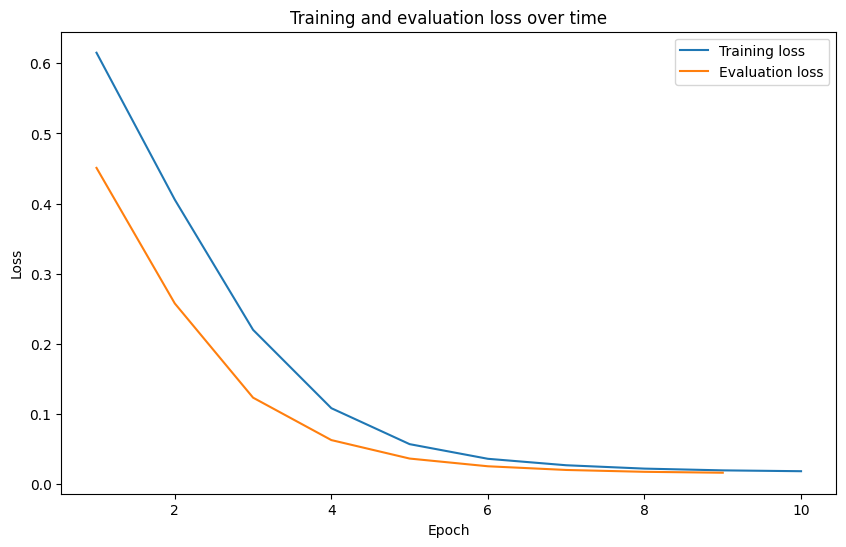

In [88]:
# Plot training and evaluation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(trainer_history_training_df["epoch"], trainer_history_training_df["loss"], label="Training loss")
plt.plot(trainer_history_eval_df["epoch"], trainer_history_eval_df["eval_loss"], label="Evaluation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and evaluation loss over time")
plt.legend()
plt.show()

### TK - Save the model for later use

In [78]:
# Save model
# See docs: https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Trainer.save_model 
trainer.save_model(model_save_dir)

### TK - Push the model to Hugging Face Hub

TK - optional to share the model/use elsewhere 

* see here: https://huggingface.co/docs/transformers/en/model_sharing 
* also see here for how to setup `huggingface-cli` so you can write your model to your account
* TK - can use `create_model_card` on Trainer to create a model card that saves a model with information about how it was trained -> https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Trainer.create_model_card 

In [79]:
# TK - have a note here for the errors
# Note: you may see the following error
# 403 Forbidden: You don't have the rights to create a model under the namespace "mrdbourke".
# Cannot access content at: https://huggingface.co/api/repos/create.
# If you are trying to create or update content,make sure you have a token with the `write` role.

In [80]:
# TK - Push model to hub (for later re-use)
# TODO: Push this model to the hub to be able to use it later
# TK - this requires a "write" token from the Hugging Face Hub
# TK - see docs: https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Trainer.push_to_hub 
# TK - for example, on my local computer, my token is saved to: "/home/daniel/.cache/huggingface/token"

# TK - Can create a model card with create_model_card()
# see here: https://huggingface.co/docs/transformers/v4.41.3/en/main_classes/trainer#transformers.Trainer.create_model_card 

trainer.push_to_hub(
    commit_message="Uploading food not food text classifier model" # set to False if you want the model to be public
    # token="YOUR_HF_TOKEN_HERE" # note: this will default to the token you have saved in your Hugging Face config
)

CommitInfo(commit_url='https://huggingface.co/mrdbourke/learn_hf_food_not_food_text_classifier-distilbert-base-uncased/commit/7c9a4a6b17da981559f484538d51f6ff9a14c12d', commit_message='Uploading food not food text classifier model', commit_description='', oid='7c9a4a6b17da981559f484538d51f6ff9a14c12d', pr_url=None, pr_revision=None, pr_num=None)

* TK - note: this will make the model public, to make it private, 

See the model here saved for later: https://huggingface.co/mrdbourke/learn_hf_food_not_food_text_classifier-distilbert-base-uncased 

### TK - Make and evaluate predictions on the test set

In [108]:
# Perform predictions on the test set
predictions_all = trainer.predict(tokenized_dataset["test"])
prediction_metrics = predictions_all.metrics
prediction_metrics

{'test_loss': 0.015632618218660355,
 'test_accuracy': 1.0,
 'test_runtime': 0.0391,
 'test_samples_per_second': 1280.07,
 'test_steps_per_second': 51.203}

In [113]:
predictions_all

PredictionOutput(predictions=array([[-2.261428 ,  1.890655 ],
       [ 1.8613493, -1.8532594],
       [-2.2970695,  1.9171791],
       [ 2.187019 , -2.1593657],
       [ 2.1193414, -2.1615388],
       [-2.2868803,  1.9454829],
       [ 2.0827348, -2.1099336],
       [ 2.154141 , -2.1266923],
       [-2.279855 ,  1.9362432],
       [-2.277952 ,  1.9518106],
       [-2.2772808,  1.9423369],
       [-1.9777709,  1.5732591],
       [ 2.1512635, -2.0508409],
       [-2.3032587,  1.9534686],
       [-2.138177 ,  1.7531359],
       [ 2.194142 , -2.1277084],
       [-2.2709608,  1.9498663],
       [ 1.9596925, -1.919577 ],
       [-2.2827635,  1.9249418],
       [-2.290854 ,  1.9592198],
       [-2.2823153,  1.8799024],
       [-2.3003585,  1.9387653],
       [ 2.043029 , -2.0384376],
       [ 2.0885575, -2.1244206],
       [-2.2873669,  1.9443382],
       [-2.2972584,  1.9009027],
       [-2.2450745,  1.8596792],
       [ 2.1050394, -2.040059 ],
       [-2.2972147,  1.8946056],
       [ 2.130

In [112]:
predictions_all._asdict().keys()

dict_keys(['predictions', 'label_ids', 'metrics'])

In [100]:
import torch
pred_probs = torch.softmax(torch.tensor(predictions_all.predictions), dim=1)
pred_labels = np.argmax(predictions_all.predictions, axis=1)
true_labels = dataset["test"]["label"]

# Calculate accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_labels, pred_labels)
accuracy

1.0

In [120]:
# Make a DataFrame of test predictions
test_predictions_df = pd.DataFrame({
    "text": dataset["test"]["text"],
    "true_label": true_labels,
    "pred_label": pred_labels,
    "pred_prob": torch.max(pred_probs, dim=1).values
})

test_predictions_df.head()

,text,true_label,pred_label,pred_prob
0,A slice of pepperoni pizza with a layer of mel...,1,1,0.984512
1,Red brick fireplace with a mantel serving as a...,0,0,0.976215
2,A bowl of sliced bell peppers with a sprinkle ...,1,1,0.985432
3,Set of mugs hanging on a hook,0,0,0.987212
4,Standing floor lamp providing light next to an...,0,0,0.986358


In [121]:
# Show 10 examples with low prediction probability
# TK - this is good to find samples where the model is unsure 
test_predictions_df.sort_values("pred_prob").head(10)

,text,true_label,pred_label,pred_prob
11,A close-up shot of a cheesy pizza slice being ...,1,1,0.972105
1,Red brick fireplace with a mantel serving as a...,0,0,0.976215
42,"Boxes of apples, pears, pineapple, manadrins a...",1,1,0.978392
17,"Relaxing on the porch, a couple enjoys the com...",0,0,0.979753
14,Two handfuls of bananas in a fruit bowl with g...,1,1,0.979990
40,A bowl of cherries with a sprig of mint for ga...,1,1,0.981236
39,A close-up of a woman practicing yoga in the l...,0,0,0.981741
43,Set of muffin tins stacked together,0,0,0.982799
22,Two people sitting at a dining room table with...,0,0,0.983398
26,A fruit platter with a variety of exotic fruit...,1,1,0.983774


## TK - Make and inspect predictions on new text data

UPTOHERE
- load the model (locally + from Hub)
    - make sure to change the save paths when loading the model to the new paths
- make predictions on new text data
- build a demo with Gradio (optional)

Making predictions on our own text options.

See: https://huggingface.co/docs/transformers/en/tasks/sequence_classification#inference

In [124]:
model_save_dir

PosixPath('models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased')

In [144]:
# Setup local model path
local_model_path = "models/learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

# Setup Hugging Face model path (see: https://huggingface.co/mrdbourke/learn_hf_food_not_food_text_classifier-distilbert-base-uncased)
huggingface_model_path = "mrdbourke/learn_hf_food_not_food_text_classifier-distilbert-base-uncased"

### TK - Pipeline mode

* Tk - what is a pipeline?

In [145]:
# TODO: TK - set device agnostic code for CUDA/Mac/CPU?
def set_device():
    """
    Set device to CUDA if available, else MPS (Mac), else CPU.

    This defaults to using the best available device (usually).
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

DEVICE = set_device()
print(f"[INFO] Using device: {DEVICE}")

[INFO] Using device: cuda


In [146]:
import torch
from transformers import pipeline

# Setup batch size for batched inference (can be adjusted depending on how much memory is available)
# TK - why use batch size? -> multiple samples at inference = faster
BATCH_SIZE = 64

food_not_food_classifier = pipeline(task="text-classification", 
                                    model=local_model_path,
                                    batch_size=BATCH_SIZE,
                                    device=DEVICE)


In [147]:
sample_text_food = "A delicious photo of a plate of scrambled eggs, bacon and toast"
food_not_food_classifier(sample_text_food)

[{'label': 'food', 'score': 0.99871826171875}]

In [148]:
sample_text_not_food = "A yellow tractor driving over the hill"
food_not_food_classifier(sample_text_not_food)

[{'label': 'not_food', 'score': 0.9989410042762756}]

In [150]:
# Pipeline also works with remote models (will have to laod the model locally first)
food_not_food_classifier_remote = pipeline(task="text-classification", 
                                           model=huggingface_model_path,
                                           batch_size=BATCH_SIZE,
                                           device=DEVICE)

food_not_food_classifier_remote("This is some new text about bananas and pancakes and ice cream")

[{'label': 'food', 'score': 0.9981549382209778}]

### TK - Batch prediction

* TK - what is batch prediction?

In [151]:
# Predicting works with lists
# Can find the examples with highest confidence and keep those
sentences = [
    "I whipped up a fresh batch of code, but it seems to have a syntax error.",
    "We need to marinate these ideas overnight before presenting them to the client.",
    "The new software is definitely a spicy upgrade, taking some time to get used to.",
    "Her social media post was the perfect recipe for a viral sensation.",
    "He served up a rebuttal full of facts, leaving his opponent speechless.",
    "The team needs to simmer down a bit before tackling the next challenge.",
    "Our budget is a bit thin, so we'll have to use budget-friendly materials for this project.",
    "The presentation was a delicious blend of humor and information, keeping the audience engaged.",
    "Daniel Bourke is really cool :D",
    "My favoruite food is biltong!"
]

food_not_food_classifier(sentences)

[{'label': 'not_food', 'score': 0.9410305619239807},
 {'label': 'not_food', 'score': 0.9650871753692627},
 {'label': 'not_food', 'score': 0.9215793609619141},
 {'label': 'not_food', 'score': 0.9115400910377502},
 {'label': 'not_food', 'score': 0.9625208377838135},
 {'label': 'not_food', 'score': 0.9476941823959351},
 {'label': 'not_food', 'score': 0.9451109170913696},
 {'label': 'not_food', 'score': 0.9027702808380127},
 {'label': 'not_food', 'score': 0.9954429864883423},
 {'label': 'food', 'score': 0.7653573155403137}]

### TK - Time our model across larger sample sizes

* TK - our model is fast!

In [142]:
%%time
import time
for i in [10, 100, 1000, 10_000]:
    sentences_big = sentences * i
    print(f"[INFO] Number of sentences: {len(sentences_big)}")

    start_time = time.time()
    food_not_food_classifier(sentences_big)
    end_time = time.time()

    print(f"[INFO] Inference time for {len(sentences_big)} sentences: {round(end_time - start_time, 5)} seconds.")
    print(f"[INFO] Avg inference time per sentence: {round((end_time - start_time) / len(sentences_big), 8)} seconds.")
    print()

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


[INFO] Number of sentences: 100
[INFO] Inference time for 100 sentences: 0.07726 seconds.
[INFO] Avg inference time per sentence: 0.0007726 seconds.

[INFO] Number of sentences: 1000
[INFO] Inference time for 1000 sentences: 0.32344 seconds.
[INFO] Avg inference time per sentence: 0.00032344 seconds.

[INFO] Number of sentences: 10000
[INFO] Inference time for 10000 sentences: 1.43834 seconds.
[INFO] Avg inference time per sentence: 0.00014383 seconds.

[INFO] Number of sentences: 100000
[INFO] Inference time for 100000 sentences: 14.4585 seconds.
[INFO] Avg inference time per sentence: 0.00014459 seconds.

CPU times: user 15.8 s, sys: 552 ms, total: 16.3 s
Wall time: 16.3 s


### PyTorch mode

In [50]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("learn_hf_food_not_food_text_classifier_model")
inputs = tokenizer(sample_text_food, return_tensors="pt")

In [53]:
import torch
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("learn_hf_food_not_food_text_classifier_model")
with torch.no_grad():
  logits = model(**inputs).logits

In [54]:
# Get predicted class
predicted_class_id = logits.argmax().item()
print(f"Text: {sample_text_food}")
print(f"Predicted label: {model.config.id2label[predicted_class_id]}")

Text: A delicious photo of a plate of scrambled eggs, bacon and toast
Predicted label: food


## TK - Turning our model into a demo

* TK - why build a demo?
    * - try our model in the wild, see samples which don't work properly, e.g. use cases we didn't think of... "pie"/"tea" (short words), "hjflasdjhfhwerr" (gibberish)
* TK - build a demo with Gradio, see it here: https://www.gradio.app/guides/quickstart 
* TK - requires `pip install gradio`

In [152]:
# Set top_k=2 to get top 2 predictions (in our case, food and not_food)
food_not_food_classifier("Testing the pipeline", top_k=2)

[{'label': 'not_food', 'score': 0.9977033734321594},
 {'label': 'food', 'score': 0.002296620048582554}]

### TK - Creating a simple function to perform inference

* TK - this is required for gradio -> output a dict of {"label_1": probability_1, "label_2": probability_2...}
* 2 options:
    * Local demo (for our own inspection)
    * Hosted demo on Hugging Face Spaces (for sharing with others)

In [160]:
import gradio as gr

def food_not_food_classifier(text):
    food_not_food_classifier = pipeline(task="text-classification", 
                                        model=local_model_path,
                                        batch_size=64,
                                        device="cuda" if torch.cuda.is_available() else "cpu",
                                        top_k=None) # return all possible scores (not just top-1)
    
    # Get outputs from pipeline (as a list of dicts)
    outputs = food_not_food_classifier(text)[0]

    # Format output for Gradio (e.g. {"label_1": probability_1, "label_2": probability_2})
    output_dict = {}

    for item in outputs:
        output_dict[item["label"]] = item["score"]

    return output_dict

food_not_food_classifier("My lunch today was bacon and eggs")

{'food': 0.7966588139533997, 'not_food': 0.20334114134311676}

In [161]:
demo = gr.Interface(
    fn=food_not_food_classifier, 
    inputs="text", 
    outputs=gr.Label(num_top_classes=2), # show top 2 classes (that's all we have)
    title="Food or Not Food Classifier",
    description="A text classifier to determine if a sentence is about food or not food.",
    examples=[["I whipped up a fresh batch of code, but it seems to have a syntax error."],
              ["A delicious photo of a plate of scrambled eggs, bacon and toast."]])

demo.launch()

Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


### TK - Uploading/running the demo

Options:
* Uploading manually to Hugging Face Spaces - hf.co/new-space 
* Uploading programmatically to Hugging Face Spaces - https://www.gradio.app/guides/using-hugging-face-integrations#hosting-your-gradio-demos-on-spaces
* Running the demo locally - `Interface.launch()` (only works if you have Gradio installed)


In [162]:
# Make a directory for demos
demos_dir = Path("../demos")
demos_dir.mkdir(exist_ok=True)

# Create a folder for the food_not_food_text_classifer demo
food_not_food_text_classifier_demo_dir = Path(demos_dir, "food_not_food_text_classifier")
food_not_food_text_classifier_demo_dir.mkdir(exist_ok=True)

In [164]:
%%writefile ../demos/food_not_food_text_classifier/app.py
import torch
import gradio as gr

from transformers import pipeline

def food_not_food_classifier(text):
    # Set up text classification pipeline
    food_not_food_classifier = pipeline(task="text-classification", 
                                        model="mrdbourke/learn_hf_food_not_food_text_classifier-distilbert-base-uncased", # link to model on HF Hub
                                        device="cuda" if torch.cuda.is_available() else "cpu",
                                        top_k=None) # return all possible scores (not just top-1)
    
    # Get outputs from pipeline (as a list of dicts)
    outputs = food_not_food_classifier(text)[0]

    # Format output for Gradio (e.g. {"label_1": probability_1, "label_2": probability_2})
    output_dict = {}
    for item in outputs:
        output_dict[item["label"]] = item["score"]

    return output_dict

description = """
A text classifier to determine if a sentence is about food or not food.

TK - See source code:
"""

demo = gr.Interface(fn=food_not_food_classifier, 
             inputs="text", 
             outputs=gr.Label(num_top_classes=2), # show top 2 classes (that's all we have)
             title="🍗🚫🥑 Food or Not Food Text Classifier",
             description=description,
             examples=[["I whipped up a fresh batch of code, but it seems to have a syntax error."],
                       ["A delicious photo of a plate of scrambled eggs, bacon and toast."]])

if __name__ == "__main__":
    demo.launch()

Overwriting ../demos/food_not_food_text_classifier/app.py


TK - note: you will often need a requirements.txt file

```
===== Application Startup at 2024-06-13 05:37:21 =====

Traceback (most recent call last):
  File "/home/user/app/app.py", line 1, in <module>
    import torch
ModuleNotFoundError: No module named 'torch'
```


In [165]:
%%writefile ../demos/food_not_food_text_classifier/requirements.txt
gradio
torch
transformers

Overwriting ../demos/food_not_food_text_classifier/requirements.txt


Create a `README.md` file with metadata instructions (these are specific to Hugging Face Spaces).

In [166]:
%%writefile ../demos/food_not_food_text_classifier/README.md
---
title: Food Not Food Text Classifier
emoji: 🍗🚫🥑
colorFrom: blue
colorTo: yellow
sdk: gradio
sdk_version: 4.36.1
app_file: app.py
pinned: false
license: apache-2.0
---

# 🍗🚫🥑 Food Not Food Text Classifier

Small demo to showcase a text classifier to determine if a sentence is about food or not food.

DistillBERT model fine-tuned on a small synthetic dataset of 250 generated [Food or Not Food image captions](https://huggingface.co/datasets/mrdbourke/learn_hf_food_not_food_image_captions).

TK - see the demo notebook on how to create this

Overwriting ../demos/food_not_food_text_classifier/README.md


In [167]:
from huggingface_hub import (
    create_repo,
    get_full_repo_name,
    upload_file, # for uploading a single file
    upload_folder # for uploading multiple files (in a folder)
)

path_to_demo_folder = "../demos/food_not_food_text_classifier"
repo_type = "space" # we're creating a Hugging Face Space

# Create a repo on Hugging Face
# see docs: https://huggingface.co/docs/huggingface_hub/v0.23.3/en/package_reference/hf_api#huggingface_hub.HfApi.create_repo
target_space_name = "learn_hf_food_not_food_text_classifier_demo"
print(f"[INFO] Creating repo: {target_space_name}")
create_repo(
    repo_id=target_space_name,
    #token="YOUR_HF_TOKEN"
    private=False, # set to True if you want the repo to be private
    repo_type=repo_type, # create a Hugging Face Space
    space_sdk="gradio", # we're using Gradio to build our demo 
    exist_ok=True, # set to False if you want to create the repo even if it already exists            
)

# Get the full repo name (e.g. "mrdbourke/learn_hf_food_not_food_text_classifier_demo")
full_repo_name = get_full_repo_name(model_id=target_space_name)
print(f"[INFO] Full repo name: {full_repo_name}")

# Upload a file
# see docs: https://huggingface.co/docs/huggingface_hub/v0.23.3/en/package_reference/hf_api#huggingface_hub.HfApi.upload_file 
print(f"[INFO] Uploading {path_to_demo_folder} to repo: {full_repo_name}")
file_url = upload_folder(
    folder_path=path_to_demo_folder,
    path_in_repo=".", # save to the root of the repo
    repo_id=full_repo_name,
    repo_type=repo_type,
    #token="YOUR_HF_TOKEN"
    commit_message="Uploading food not food text classifier demo app.py"
)

[INFO] Creating repo: learn_hf_food_not_food_text_classifier_demo
[INFO] Full repo name: mrdbourke/learn_hf_food_not_food_text_classifier_demo
[INFO] Uploading ../demos/food_not_food_text_classifier to repo: mrdbourke/learn_hf_food_not_food_text_classifier_demo


* TK - see the demo link here: https://huggingface.co/spaces/mrdbourke/learn_hf_food_not_food_text_classifier_demo 

### TK - Testing the live demo

In [1]:
from IPython.display import HTML


# You can get embeddable HTML code for your demo by clicking the "Embed" button on the demo page
HTML('''
<iframe
	src="https://mrdbourke-learn-hf-food-not-food-text-classifier-demo.hf.space"
	frameborder="0"
	width="850"
	height="450"
></iframe>     
''')

## TK - Exercises and Extensions

* Reading: 
    * Spend 15 minutes reading the TrainingArguments documentation - https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments 
    * Spend 10 minutes reading the Trainer documentation - https://huggingface.co/docs/transformers/en/main_classes/trainer#trainer 
* Where does our model fail? E.g. what kind of sentences does it struggle with? How could you fix this? 
    * Make an extra 10-50 examples of these and add them to the dataset and then retrain the model
    * See here: https://discuss.huggingface.co/t/how-do-i-add-things-rows-to-an-already-saved-dataset/27423 
* Build your own text classifier on a different dataset/your own custom dataset
* How might we make our dataset multi-class? (e.g. more than 2 classes)

## TK - Extra resources

* Hugging Face guide on text classification: https://huggingface.co/docs/transformers/en/tasks/sequence_classification 
* Hugging Face documentation on padding and truncation - https://huggingface.co/docs/transformers/en/pad_truncation 
* For more on Transformers (the architecture) as well as the DistilBert model:
    - Read [*Transformers from scratch*](https://peterbloem.nl/blog/transformers) by Peter Bloem.
    - Watch [Andrej Karpathy's lecture on Transformers and their history](https://www.youtube.com/watch?v=XfpMkf4rD6E).
    - Read the original [*Attention is all you need*](https://arxiv.org/abs/1706.03762) paper (the paper that introduced the Transformer architecture).
    - Read the [*DistilBert paper*](https://arxiv.org/abs/1910.01108) from the Hugging Face team (paper that introduced the DistilBert architecture and training setup).
